# **Trial-1**

Original Image


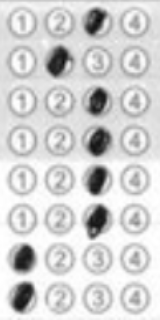

Otsu Thresholding


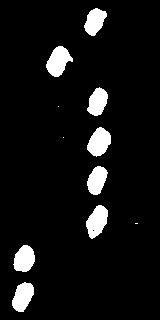

x, y coords of bubbles and FFT value
12 282 230.25050769897777
13 245 228.60283006982613
86 205 231.96095116774103
87 166 227.92670934721707
87 127 231.53489955366365
87 87 227.6961592437957
46 46 232.19378266805074
84 8 228.3799865387613
Marks: 2
Marked Answers: [3, 2, 3, 3, 3, 3, 1, 1]
Image with Bounding Boxes


<ipython-input-2-5184bd735b16>:39: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log(np.abs(fft_shift))


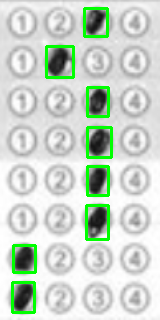

Image with Marked Answers


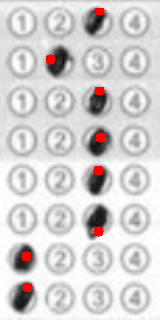

Original Image


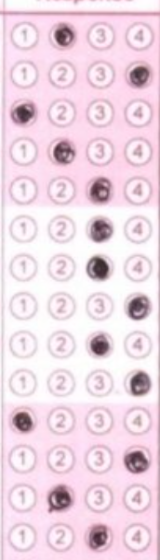

Otsu Thresholding


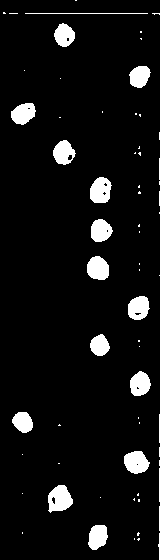

x, y coords of bubbles and FFT value
88 525 224.96747619814602
48 485 229.62869595757718
124 451 228.71332758846552
12 412 222.1156790496224
130 371 227.1674941024326
90 334 220.18647372587114
128 296 224.5647780299649
87 256 221.49306067771892
91 219 224.96747619814602
90 177 223.80475566639265
53 140 224.36034694853416
11 103 217.08939048400427
129 66 223.59236428984343
54 23 220.60402542630226
Marks: 2
Marked Answers: [2, 4, 1, 2, 3, 3, 3, 4, 3, 4, 1, 4, 2, 3]
Image with Bounding Boxes


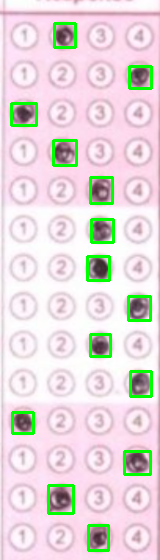

Image with Marked Answers


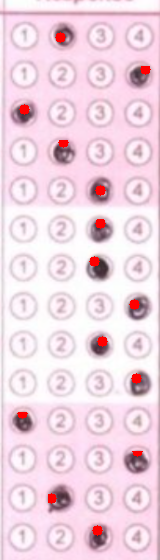

Original Image


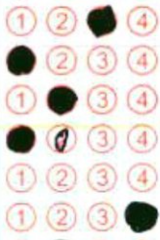

Otsu Thresholding


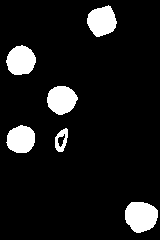

x, y coords of bubbles and FFT value
125 202 244.2152327003261
55 128 214.5729870199836
6 125 239.09445004651565
47 86 240.3339252372503
6 45 240.63974159321867
87 5 241.0601774960631
Marks: 2
Marked Answers: [3, 1, 2, 1, None, 4]
Image with Bounding Boxes


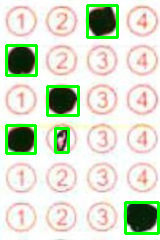

Image with Marked Answers


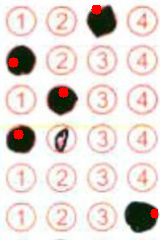

Original Image


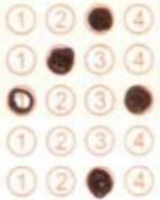

Otsu Thresholding


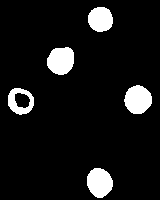

x, y coords of bubbles and FFT value
87 168 236.65665369433495
8 88 228.82321797481836
124 85 237.59715246723218
47 47 236.80425584028737
88 7 232.00773481480445
Marks: 0
Marked Answers: [3, 2, 4, None, 3]
Image with Bounding Boxes


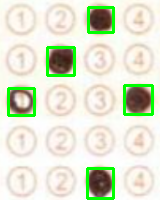

Image with Marked Answers


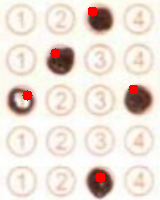

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Find the shaded/dark portions of the omr sheet
def find_contours(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255,
    cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    print("Otsu Thresholding")
    cv2_imshow(thresh)
    contours, _ = cv2.findContours(thresh,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Find the portions that form a bubble shape and
# draw bounding rectangle
def detect_bubbles(contours, image):
    bubble_data = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 50:
            x, y, w, h = cv2.boundingRect(contour)
            if w > 10 and h > 10:
                bubble_data.append((x, y, w, h))
                cv2.rectangle(image, (x, y),
                (x + w, y + h), (0, 255, 0), 2)
    return bubble_data, image

# Find the answers that are actually marked
def find_marked_answers(bubble_data, image, num_q):
    marked_answers = [None] * num_q
    print("x, y coords of bubbles and FFT value")
    for x, y, w, h in bubble_data:
        roi = image[y:y+h, x:x+w]
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        #cv2_imshow(binary)
        fft = np.fft.fft2(binary)
        fft_shift = np.fft.fftshift(fft)
        magnitude_spectrum = 20 * np.log(np.abs(fft_shift))

        # Find the maximum value in the magnitude spectrum
        max_val = np.max(magnitude_spectrum)
        print(x, y, max_val)

        # Apply inverse shift
        f_ishift = np.fft.ifftshift(fft_shift)
        img_back = np.fft.ifft2(f_ishift)
        img_back = np.abs(img_back)

        # Find the question no. and choice no.
        i = image.shape[0]
        j = image.shape[1]
        cdiv = (j // 4)
        nq = i // cdiv
        rdiv = (i // nq)

        # Find the darkest point
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(img_back)

        # If max_frequency is above a threshold, then it is a marked answer
        if max_val > 215:
            marked_answers[y // rdiv] = (x // cdiv) + 1
            cv2.circle(roi, maxLoc, 5, (0, 0, 255), -1)

    return marked_answers, image

# Evaluate the marks
def evaluate_omr(image_path, num_questions):
    image = cv2.imread(image_path)
    answers = [1] * num_questions
    score = 0

    # Resize the image so that a common threshold can be followed
    image = cv2.resize(image, (160, (160 // 4) * num_questions))
    print("Original Image")
    cv2_imshow(image)
    # Find the contours
    contours = find_contours(image)

    # Draw the bounding rectangle and shaded bubbles
    bubble_data, image_with_boxes = detect_bubbles(contours, image.copy())

    # Find the marked answers
    marked_answers, image_with_marked = find_marked_answers(bubble_data,
                                            image.copy(), num_questions)

    # Score based on marked answers
    for i in range(len(answers)):
        if answers[i] == marked_answers[i]:
            score += 1

    # Display results
    print("Marks:", score)
    print("Marked Answers:", marked_answers)
    print("Image with Bounding Boxes")
    cv2_imshow(image_with_boxes)
    print("Image with Marked Answers")
    cv2_imshow(image_with_marked)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    images = [2, 3, 4, 5]
    questions = [8, 14, 6, 5]
    for i in range(len(images)):
        image_path = "omr_sheet" + str(images[i]) + ".png"
        evaluate_omr(image_path, questions[i])